In [1]:
import os,sys
import numpy as np
# xarray
import xarray as xr

In [2]:
# plot
import matplotlib.pyplot as plt
from matplotlib.colors import Colormap

import matplotlib.colors as mcolors
import matplotlib.dates as mdates
import matplotlib.cm as cm
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
from matplotlib.colors import from_levels_and_colors
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

In [3]:
from dask.distributed import Client
c = Client()
c

/linkhome/rech/genlop01/uor98hu/.local/lib/python3.9/site-packages/distributed/node.py:183: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 32819 instead
  warnings.warn(


# vielle façon de calculer

In [4]:
nexpREF = "GAI"

In [5]:
# ------------------------
# loading data
# ------------------------
diro = "/gpfsscratch/rech/cli/uor98hu/BILANS/"+nexpREF+"/" 
diri="/gpfswork/rech/cli/rcli002/eORCA025.L75/eORCA025.L75-I/"
mesh_hgr=xr.open_dataset(diri+'mesh_hgr.nc').squeeze()

tmask = mesh_hgr.tmask.rename({'nav_lev':"deptht"})
tmaskutil = mesh_hgr.tmaskutil

e1t = mesh_hgr.e1t.fillna(0)
e2t = mesh_hgr.e2t.fillna(0)
e2u = mesh_hgr.e2u.fillna(0)
e1v = mesh_hgr.e1v.fillna(0)

nav_lon =  mesh_hgr.nav_lon
nav_lat =  mesh_hgr.nav_lat


In [6]:
chunk_size = {"x":500,"y":500}

prefix = "eORCA025.L75-IMHOTEP"
diridatref="/gpfsstore/rech/cli/rcli002/eORCA025.L75/"+prefix+"."+nexpREF+"-S/"

In [7]:
# load data dSdt
dirsc= "/gpfsscratch/rech/cli/uor98hu/BILANS/GAI/dSdt/gpfsscratch/rech/cli/uor98hu/BILANS/GAI/dSdt/"
dSdt = xr.open_mfdataset(dirsc+"GAI_dSdt_1m*.nc", parallel=True, chunks={"x":133,"y":320,'deptht':40}).dSdt.squeeze()

In [8]:
nbsec  = xr.open_dataset('/gpfswork/rech/cli/uor98hu/MYDATA/BILAN/BILANS/nbsec_1m.nc',chunks={'time_counter':1}).nbsec

In [9]:
## processing (suite)

In [10]:
maskBG = xr.open_dataset('/gpfswork/rech/cli/uor98hu/MYDATA/TRANSPORT_WP1/BGRmaskobs.nc').BGRmask.squeeze()

In [11]:
bgr_dSdt =  dSdt.where(maskBG,drop=True)

In [12]:
bgr_dSdt.time_counter

<xarray.DataArray 'time_counter' (time_counter: 468)>
array(['1980-01-16T12:00:00.000000000', '1980-02-15T12:00:00.000000000',
       '1980-03-16T12:00:00.000000000', ..., '2018-10-16T12:00:00.000000000',
       '2018-11-16T00:00:00.000000000', '2018-12-16T12:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time_counter  (time_counter) datetime64[ns] 1980-01-16T12:00:00 ... 2018-...

In [13]:
%%time
# read e3t
prefix = "eORCA025.L75-IMHOTEP"
diridatref="/gpfsstore/rech/cli/rcli002/eORCA025.L75/"+prefix+"."+nexpREF+"-S/"
# years to read data from:
bgr_e3t = xr.open_mfdataset(diridatref+"1m/????/*1m_gridT.nc",decode_coords=False,chunks={"x":133,"y":320,'deptht':40}\
                            ,parallel=True).e3t.where(maskBG,drop=True)

CPU times: user 7.58 s, sys: 416 ms, total: 8 s
Wall time: 20.9 s


In [15]:
bgr_e1t = e1t.where(maskBG,drop=True)
bgr_e2t = e2t.where(maskBG,drop=True)

In [16]:
# gridcell volume
btbox = bgr_e3t*bgr_e2t*bgr_e1t

# --------------------
# Budget in the box full depth
# --------------------
voltotal = btbox.sum(("deptht","y","x"))#.compute()

bgr_dSdt_mean = (bgr_dSdt * btbox).sum(("deptht","y","x")) / voltotal

# --------------------
# retirer la time mean de toutes les séries temporelles 
# --------------------
bgr_dSdt_mean_prime = bgr_dSdt_mean - bgr_dSdt_mean.mean()

In [17]:
# dSdt averaged over the box BGR 
bgr_dSdt_mean_comp = bgr_dSdt_mean.compute()

In [ ]:
# dSdt averaged over the box BGR with the time mean retrieved
bgr_dSdt_mean_prime_comp = bgr_dSdt_mean_prime.compute()

In [44]:
# time-integrated dS averaged over the box BGR with the time mean retrieved
bgr_dSdt_mean_prime_compcumsum = (bgr_dSdt_mean_prime_comp*nbsec).cumsum().compute()


In [18]:
# ce que j'aurais du faire: je ne change qu'un paramètre
# time-integrated dS averaged over the box BGR WITHOUT the time mean retrieved
bgr_dS_mean_compcumsum = (bgr_dSdt_mean_comp*nbsec).cumsum().compute()

In [20]:
### parenthèse: pour voir old fashion of calculating dS versus new fashion
dirww = "/gpfswork/rech/cli/uor98hu/MYDATA/BILAN/BILANS/data4figure/"
new_Gtotal = xr.open_dataset(dirww+nexpREF+"_dScumsum_1980_2018_after_review.nc").dScumsum

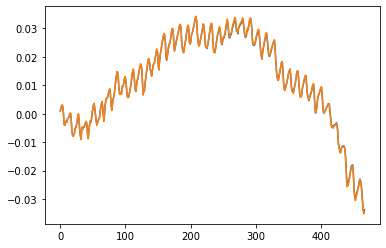

In [30]:
plt.plot(bgr_dS_mean_compcumsum[:-1])
plt.plot(new_Gtotal[:-1])

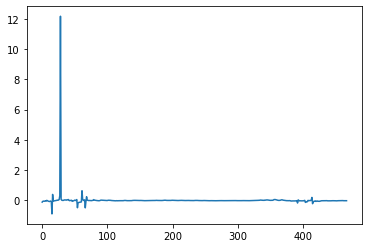

In [39]:
plt.plot((bgr_dS_mean_compcumsum[:-1] - new_Gtotal[:-1])/new_Gtotal[:-1])

In [ ]:
#### conclusion: il n'y a pas de différence significative entre l'ancienne méhode et la nouvelle méthode pour calculer le Gtotal mais il y a un point qui était largement faux qui a été corrigé. 

In [92]:
# time-integrated dS averaged over the box BGR with its own time mean retrieved retrieved
bgr_dS_mean_compcumsum_nomean = bgr_dS_mean_compcumsum - bgr_dS_mean_compcumsum.mean()

In [94]:
bgr_dS_mean_compcumsum.mean()

<xarray.DataArray ()>
array(0.01147801)

In [97]:
# en enlevant la première valeur 
bgr_dS_mean_compcumsum_min1val = bgr_dS_mean_compcumsum - bgr_dS_mean_compcumsum[0]


In [66]:
# bgr_dSdt_mean_comp.plot()
# bgr_dSdt_mean_prime_comp.plot()

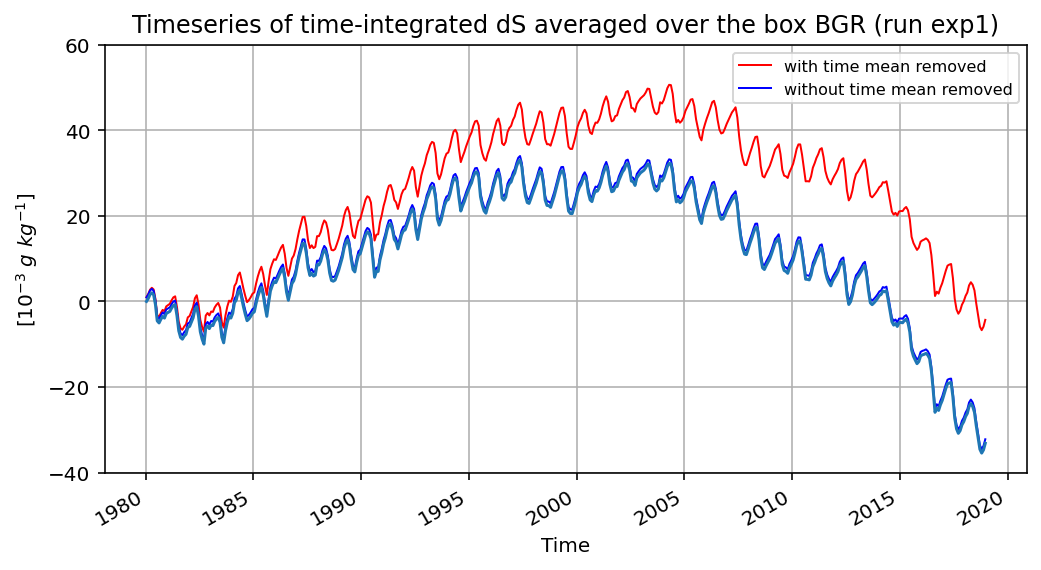

In [98]:

cm = 1/2.54  # centimeters in inches
fig = plt.figure(figsize=(21*cm, 10*cm), facecolor='none', dpi=72*2)

(1e3*bgr_dSdt_mean_prime_compcumsum).plot(color='r', linewidth=1)
(1e3*bgr_dS_mean_compcumsum).plot(color='b', linewidth=1)
# (1e3*bgr_dS_mean_compcumsum_min1val).plot()


plt.legend(["with time mean removed","without time mean removed"], fontsize=8)
plt.ylabel(r"[$10^{-3}$ $g$ $kg^{-1}$]")
plt.xlabel("Time")

plt.title("Timeseries of time-integrated dS averaged over the box BGR (run exp1)")
plt.grid()
plt.ylim(-40,60)

# plt.show()

diro = "/gpfsscratch/rech/cli/uor98hu/PLOTS/" # plot directory
namo = 'ts_exp1_Gtotal_mean_removed_vs_mean_not_removed.jpg'

# fig.savefig(diro+namo, facecolor=fig.get_facecolor(), bbox_inches='tight', transparent=True) #,edgecolor='none', bbox_inches='tight'


# morale: changer dans la figure 5: ne pas nelever de time-mean à aucun omment. à la limite enlever la first value de la série dejà en cumsum. 

In [71]:
dirww = "/gpfswork/rech/cli/uor98hu/MYDATA/BILAN/BILANS/data4figure/"

In [75]:
maskname = 'BGRmaskobs'
ww_dS = xr.open_dataset(dirww + "averageGAI_Sbudgetterms1980_2018_1m_000_bottom_"+maskname+".nc").dSdt_boxtscomp 
ww_dScumsum = (ww_dS*nbsec).cumsum().compute()


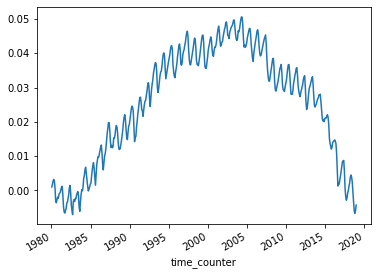

In [76]:
ww_dScumsum.plot()